# Calculate NFL Lineups for DraftKings Contests

# Clones, installs, and imports


## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [ ]:
!git clone https://github.com/zlisto/Daily-Fantasy-Football-DraftKings

import os
os.chdir("Daily-Fantasy-Football-DraftKings")

## Install Requirements


In [ ]:
!pip install pulp

## Import Packages

In [4]:
import pulp
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import glob
from data_cleaning import *
from lineup_optimizer import *

# Lineup Parameters

`nlineups` = number of lineups to enter 

`noverlap` = maximum number of players that can be shared between a pair of lineups

`max_use` = maximum number of lineups a player can be in

`qb_stack`  = how many wide receivers to stack with a quarterback in a lineup

In [6]:
nlineups = 150
noverlap = 4
max_use = 30
qb_stack = 1

path = '2025-09-07'

# Load Data

In [7]:
fname_salary, fname_entries, fname_lineups, fname_proj_offense, fname_proj_defense = create_filenames(path)
df = load_data(fname_salary, fname_proj_offense, fname_proj_defense)

Found offense projections: 2025-09-07\DFN NFL Offense DK 9_6.csv
Found defense projections: 2025-09-07\DFN NFL Defense DK 9_6.csv
Found salary file: 2025-09-07\DKSalaries.csv


# Create Data Matrices for Optimization

14 games between 26 teams, 369 players


KeyError: 'CHI'

# Calculate Lineups

In [10]:
%%time
X = np.zeros((nplayers, nlineups))

for lineup in range(nlineups):
    prob = pulp.LpProblem(f"DK_Lineup_{lineup}", pulp.LpMaximize)

    # Player variables
    xplayer = [pulp.LpVariable(f'player_{i:03}',cat="Binary") for i in range(nplayers)]
    #game variables
    xgame = [pulp.LpVariable(f'game_{i:03}',cat="Binary") for i in range(ngames)]
    #team variables
    xteam = [pulp.LpVariable(f'team_{i:03}',cat="Binary") for i in range(nteams)]
    #qb-receiver stack variables
    xqb_rec = [pulp.LpVariable(f'qb_rec_{i:03}', cat="Binary") for i in range(nteams)]
    
    # Define the objective function: Proj FP * x
    objective = pulp.lpSum([Proj[i] * xplayer[i] for i in range(nplayers)])
    prob += objective

    #Define Position constraints: Pos* x= pi
    prob += (pulp.lpSum([RB[i] * xplayer[i] for i in range(nplayers)]) >= 2, "RB_lower")
    prob += (pulp.lpSum([RB[i] * xplayer[i] for i in range(nplayers)]) <= 2, "RB_upper")
    prob += (pulp.lpSum([WR[i] * xplayer[i] for i in range(nplayers)]) >= 4, "WR_LOWER")    
    prob += (pulp.lpSum([WR[i] * xplayer[i] for i in range(nplayers)]) <= 4, "WR_UPPER")   
    prob += (pulp.lpSum([TE[i] * xplayer[i] for i in range(nplayers)]) >= 1, "TE_LOWER")    
    prob += (pulp.lpSum([TE[i] * xplayer[i] for i in range(nplayers)]) <= 1, "TE_UPPER")       
    prob += (pulp.lpSum([QB[i] * xplayer[i] for i in range(nplayers)]) == 1, "QB")
    prob += (pulp.lpSum([DST[i] * xplayer[i] for i in range(nplayers)]) == 1, "DST")
    
    #Define total players constraint: 1*x = 9
    prob += (pulp.lpSum([xplayer[i] for i in range(nplayers)]) == 9, "9_players")

    #Define salary constriant: Salary*x <=50000
    prob += (pulp.lpSum([Salary[i] * xplayer[i] for i in range(nplayers)]) <= 50000, "Salary")
    
    # 2 different games constraints
    for j in range(ngames):
        prob += (pulp.lpSum([Games[i,j] * xplayer[i] for i in range(nplayers)]) >= xgame[j], f"Game_{j}")
    prob += (pulp.lpSum([xgame[i] for i in range(ngames)]) >= 2, f"Games")
    
   # 2 different teams constraints
    for j in range(nteams):
        prob += (pulp.lpSum([Teams[i,j] * xplayer[i] for i in range(nplayers)]) >= xteam[j], f"Team_{j}")
    prob += (pulp.lpSum([xteam[i] for i in range(nteams)]) >= 2, f"Teams")  
     
    #QB - WR Stack - Put 1 QB with 2 WR 
    for j in range(nteams):
        prob += (pulp.lpSum([((8-qb_stack)*QB[i] + WR[i])*Teams[i,j] * xplayer[i] for i in range(nplayers)]) >= 8*xqb_rec[j]
                 , f"qb_rec_stack_{j}")
    prob += (pulp.lpSum([xqb_rec[i] for i in range(nteams)]) >= 1, f"qb_rec_stacks")
       
    #NO DST VS Offense  constraint
    for j in range(nteams):
        prob += (pulp.lpSum([((1-DST[i])*Teams[i,j] + 8*DST[i]*Opps[i,j]) * xplayer[i] for i in range(nplayers)]) <=8, 
                 f"No_DST_Offense_{j}")
    
    #No QB and RB on same team, no RB and RB on same team
    for j in range(nteams):
        prob += (pulp.lpSum([(QB[i] + RB[i])*Teams[i,j] * xplayer[i] for i in range(nplayers)]) <=1, 
                 f"No_DST_Offense_Team_{j}")
    
    #No WR/TE and RB on same team
    for j in range(nteams):
        prob += (pulp.lpSum([(2*RB[i] + WR[i] + TE[i])*Teams[i,j] * xplayer[i] for i in range(nplayers)]) <=2, 
                 f"No_RB_Rec_Team_{j}")
    
    #CAP PlAYER USAGE IN LINEUPS    
    if lineup >=1:        
        for j in range(nplayers):
            z = X[j,:]
            prob += (pulp.lpSum([z[i]  for i in range(lineup)])* xplayer[j] <= max_use, f"Max_use_player_{j}")
    
    #Overlap constraints: X[:,j]*x <=noverlap
    if lineup >=1:        
        for j in range(lineup):
            #print(f"\tLineup {lineup}:{j} overlap constraint")
            z = X[:,j]
            prob += (pulp.lpSum([z[i] * xplayer[i] for i in range(nplayers)]) <= noverlap, f"Overlap_{lineup}_{j}")
    
    ########################################################################
    # Solve the problem
    prob.solve()
    new_lineup = np.array( [v.varValue for v in prob.variables() if 'player_' in str(v)])
  
    X[:,lineup] = new_lineup 
    lineup_salary = df.iloc[new_lineup==1]['Salary'].sum()

    # Print the optimal objective value
    print(f"Lineup {lineup+1}: {pulp.LpStatus[prob.status]}: Objective ={pulp.value(prob.objective):.2f}, Salary =${lineup_salary:,}")
X=X.T
print(f"Saving lineups to {fname_lineups}")
df_lineups = write_lineups(X, df, fname_lineups)
df_lineups

Lineup 1: Optimal: Objective =134.70, Salary =$50,000
Lineup 2: Optimal: Objective =134.40, Salary =$50,000
Lineup 3: Optimal: Objective =133.90, Salary =$49,900
Lineup 4: Optimal: Objective =133.00, Salary =$50,000
Lineup 5: Optimal: Objective =132.70, Salary =$49,900
Lineup 6: Optimal: Objective =132.20, Salary =$49,900
Lineup 7: Optimal: Objective =132.10, Salary =$50,000
Lineup 8: Optimal: Objective =131.80, Salary =$49,900
Lineup 9: Optimal: Objective =131.80, Salary =$49,900
Lineup 10: Optimal: Objective =131.70, Salary =$50,000
Lineup 11: Optimal: Objective =131.60, Salary =$50,000
Lineup 12: Optimal: Objective =131.50, Salary =$49,900
Lineup 13: Optimal: Objective =131.50, Salary =$50,000
Lineup 14: Optimal: Objective =131.50, Salary =$50,000
Lineup 15: Optimal: Objective =131.40, Salary =$50,000
Lineup 16: Optimal: Objective =131.30, Salary =$49,900
Lineup 17: Optimal: Objective =131.20, Salary =$50,000
Lineup 18: Optimal: Objective =131.10, Salary =$50,000
Lineup 19: Optimal:

Lineup 150: Optimal: Objective =119.70, Salary =$50,000
Saving lineups to 2023-11-12/lineups.csv
Wall time: 5min 25s


,QB,RB,RB.1,WR,WR.1,WR.2,TE,FLEX,DST
0,Dak Prescott (30754548),Joe Mixon (30754630),Rachaad White (30754638),CeeDee Lamb (30754852),DeAndre Hopkins (30754876),Marquise Brown (30754896),Trey McBride (30755246),Noah Brown (30754932),Cowboys (30755438)
1,Joe Burrow (30754547),Bijan Robinson (30754634),Rachaad White (30754638),Amon-Ra St. Brown (30754854),Diontae Johnson (30754892),Marquise Brown (30754896),Trey McBride (30755246),Tyler Boyd (30754904),Cowboys (30755438)
2,Geno Smith (30754553),Joe Mixon (30754630),Najee Harris (30754652),Amon-Ra St. Brown (30754854),Tyler Lockett (30754874),Tank Dell (30754890),Trey McBride (30755246),Marquise Brown (30754896),Cowboys (30755438)
3,Jared Goff (30754549),Joe Mixon (30754630),Bijan Robinson (30754634),Amon-Ra St. Brown (30754854),DeAndre Hopkins (30754876),Calvin Ridley (30754886),Trey McBride (30755246),Marquise Brown (30754896),Bengals (30755452)
4,Geno Smith (30754553),Joe Mixon (30754630),Rachaad White (30754638),Amon-Ra St. Brown (30754854),DeAndre Hopkins (30754876),Marquise Brown (30754896),Evan Engram (30755232),Jaxon Smith-Njigba (30754916),Ravens (30755440)
...,...,...,...,...,...,...,...,...,...
145,Sam Howell (30754552),James Conner (30754636),Alexander Mattison (30754640),Keenan Allen (30754848),Drake London (30754888),Jahan Dotson (30754900),Dalton Schultz (30755228),Michael Thomas (30754906),Ravens (30755440)
146,Baker Mayfield (30754562),Aaron Jones (30754628),James Conner (30754636),Ja'Marr Chase (30754850),Chris Olave (30754868),Jordan Addison (30754880),Dalton Schultz (30755228),Trey Palmer (30754966),Buccaneers (30755445)
147,Dak Prescott (30754548),Austin Ekeler (30754610),James Conner (30754636),Chris Olave (30754868),Jordan Addison (30754880),Drake London (30754888),Chig Okonkwo (30755254),Brandin Cooks (30754910),Ravens (30755440)
148,Brock Purdy (30754555),Austin Ekeler (30754610),Aaron Jones (30754628),Brandon Aiyuk (30754858),Chris Olave (30754868),Robert Woods (30754918),Dalton Schultz (30755228),Michael Wilson (30754944),Buccaneers (30755445)


## Update Entries

Use the `update_entries` function to directly update the DraftKings DKEntries file with your new lineups.  Do this if you already calculated your lineups.  I wrote this to save an extra copy and paste step from the lineups file to the entries file.

In [11]:
df_entries = update_entries(fname_entries, df_lineups)

## Teams in Lineup

This creates a dataframe `df_lineups_team` that lets you see which positions are stacked with the quarterback.

In [12]:
# Create a mapping from "Name + ID" to "Team"
name_to_team = df.set_index('Name + ID')['Team'].to_dict()

# Replace player names in df_lineups with their teams
df_lineups_team = df_lineups.replace(name_to_team)


In [13]:
df_lineups_team.head(10)

,QB,RB,RB.1,WR,WR.1,WR.2,TE,FLEX,DST
0,DAL,CIN,TB,DAL,TEN,ARI,ARI,HOU,DAL
1,CIN,ATL,TB,DET,PIT,ARI,ARI,CIN,DAL
2,SEA,CIN,PIT,DET,SEA,HOU,ARI,ARI,DAL
3,DET,CIN,ATL,DET,TEN,JAX,ARI,ARI,CIN
4,SEA,CIN,TB,DET,TEN,ARI,JAX,SEA,BAL
5,CIN,LAC,JAX,TEN,HOU,ARI,ARI,CIN,DAL
6,WAS,CIN,ATL,DET,WAS,ARI,JAX,HOU,DAL
7,DAL,PIT,HOU,DAL,DET,ARI,ARI,CIN,TB
8,DET,CIN,TB,DET,HOU,PIT,MIN,ARI,NYG
9,CIN,PIT,HOU,DET,TEN,WAS,JAX,CIN,DAL


## Plot Lineups by Position

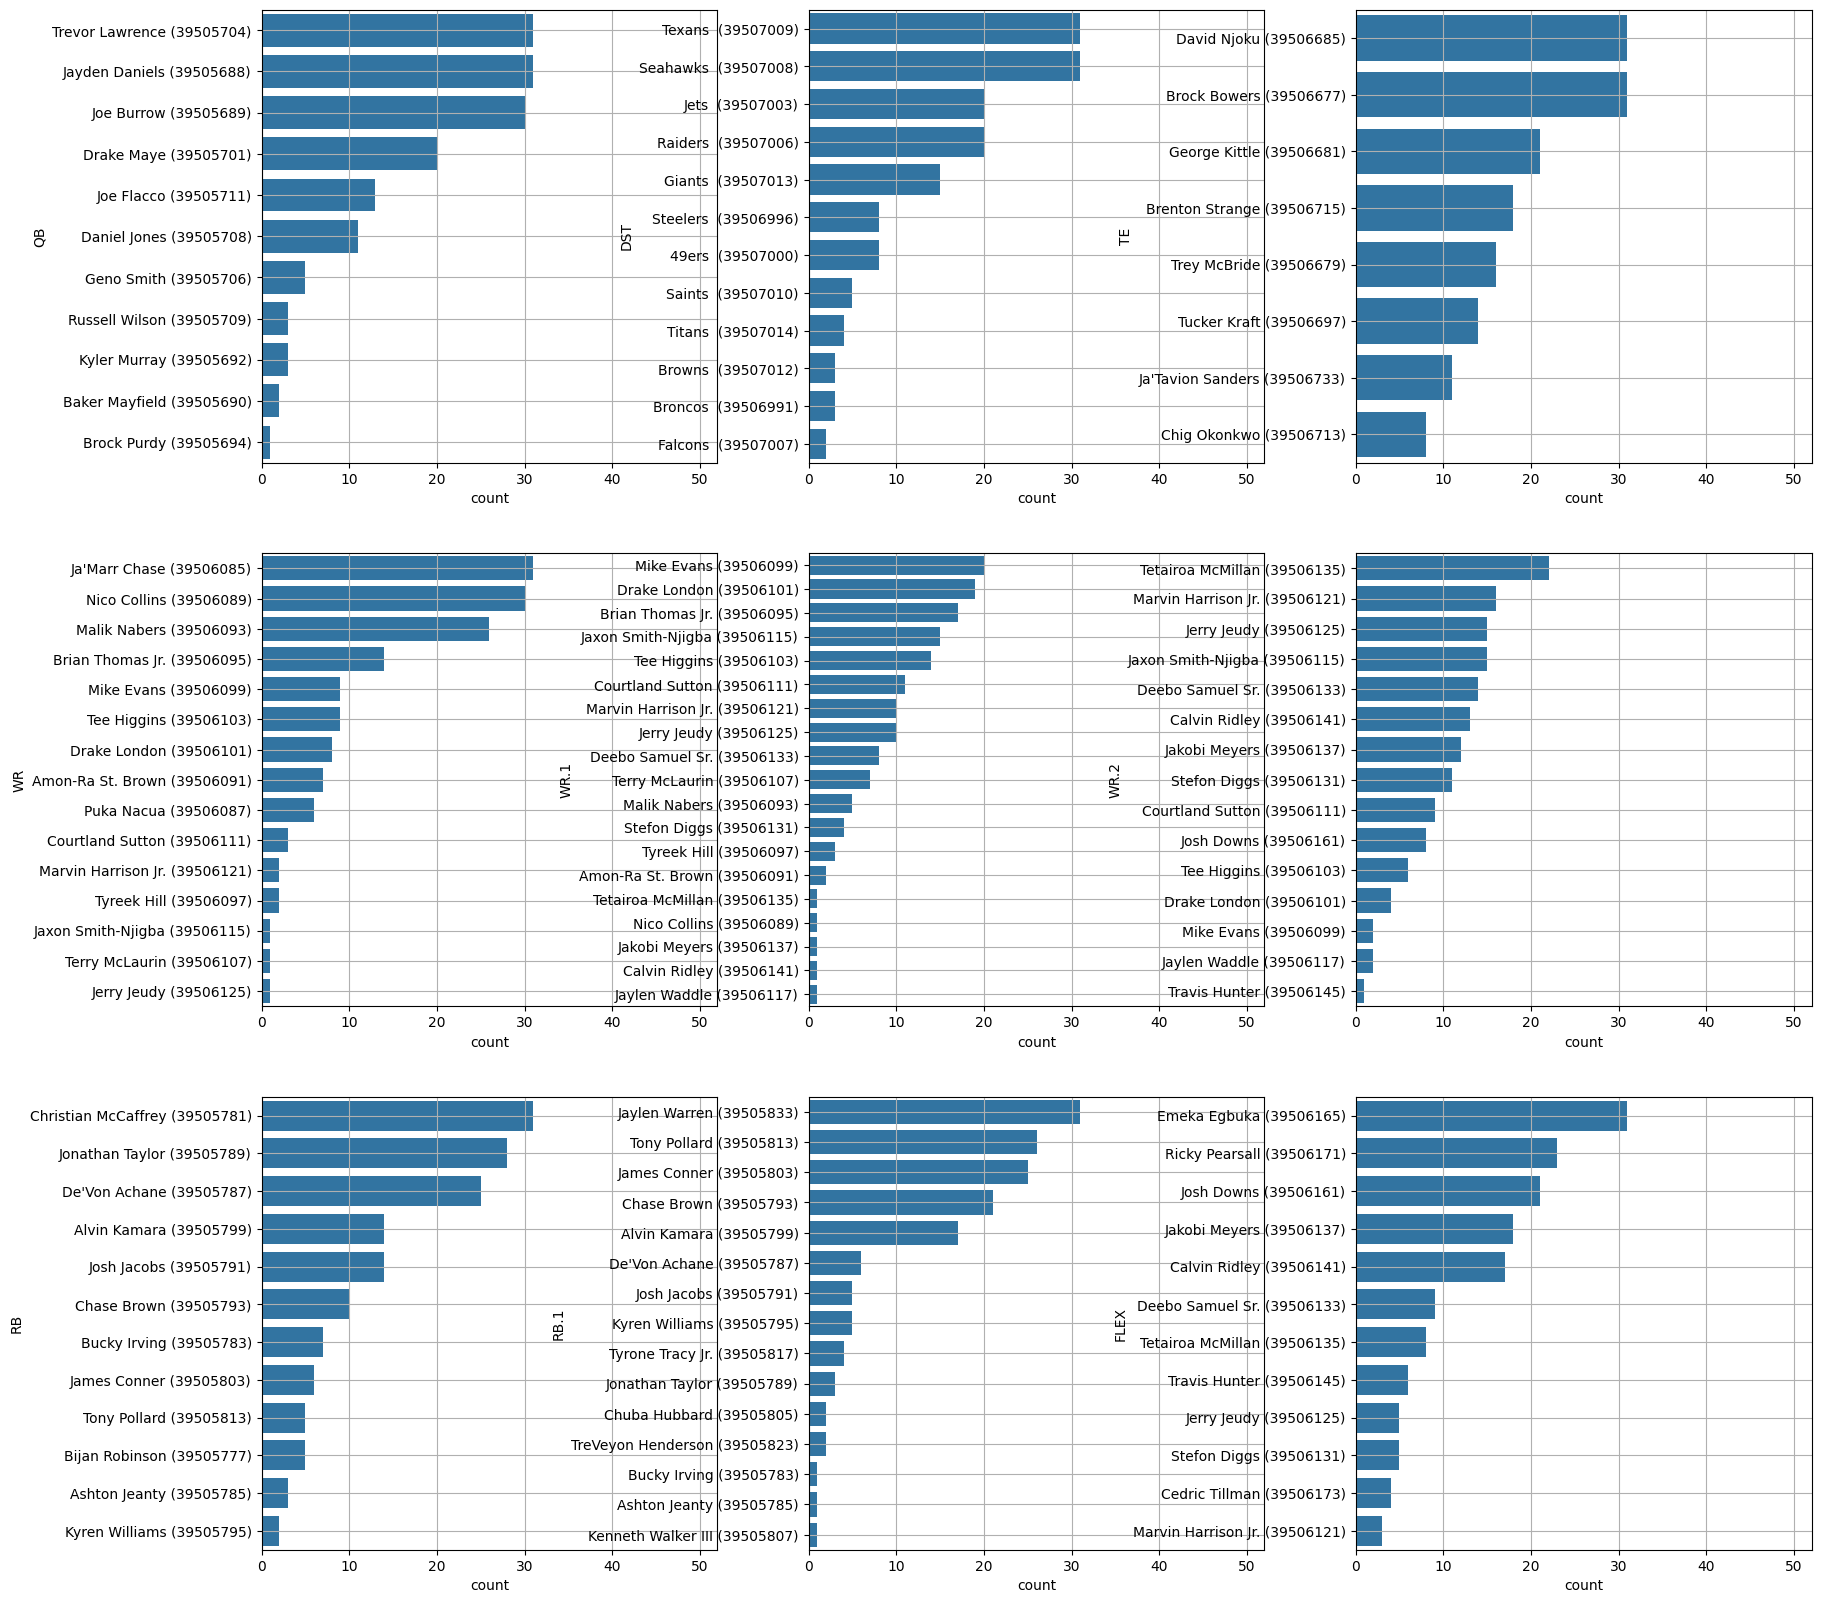

In [11]:
df_lineups = pd.read_csv(fname_lineups)
plt.figure(figsize = (20,20))
for cnt,pos in enumerate(['QB','DST','TE',
                          "WR","WR.1","WR.2", 
                          'RB','RB.1', 'FLEX',]):
    order = df_lineups[pos].value_counts().index
    plt.subplot(3,3,cnt+1)
    sns.countplot(data = df_lineups, y = pos, order = order)
    plt.grid()
    plt.xlim([0,52])
plt.show()